# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


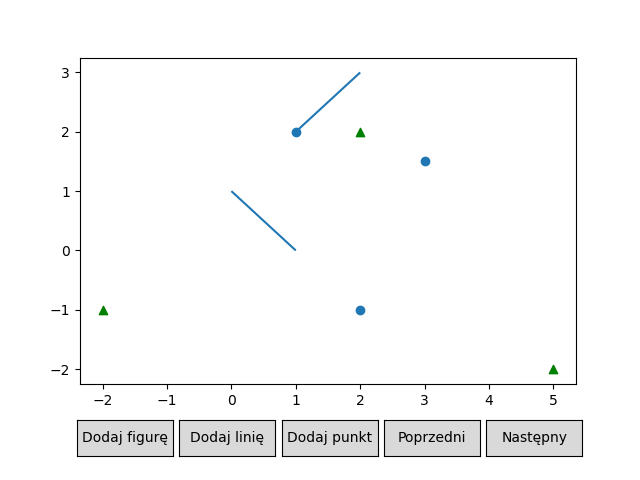

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 

### Rozwiązanie

# Generowanie danych:

In [4]:
import random
import math
import time

<IPython.core.display.Javascript object>


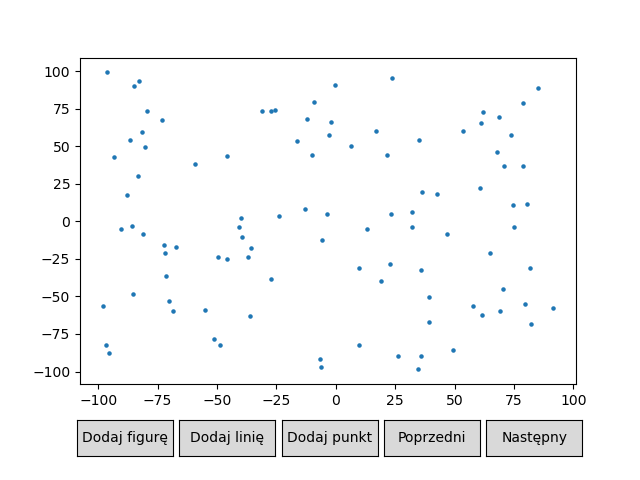

In [5]:
# n losowych punktów o współrzędnych z przedziału [a, b]

%matplotlib notebook

def generate_points(n,interval):
    a = interval[0]
    b= interval[1]
    from random import randint
    set_a = [(random.uniform(a,b),random.uniform(a,b)) for _ in range(n)]
    return set_a


# n = 100, [-100,100]
set_a = generate_points(100, [-100,100])
plot = Plot(points = [PointsCollection(set_a, s=5)])
plot.draw()

<IPython.core.display.Javascript object>


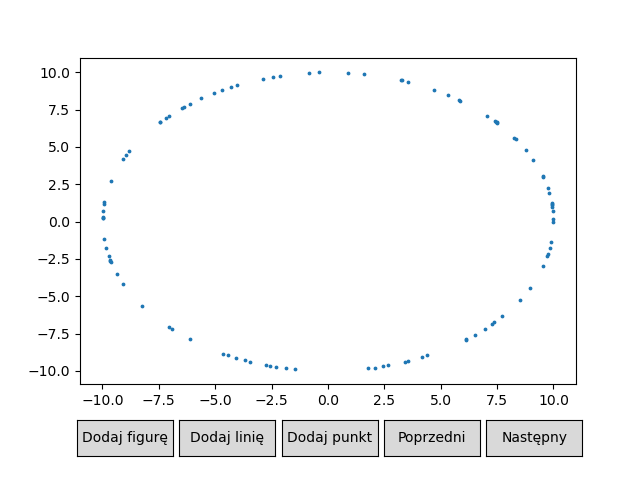

In [6]:
# n losowych punktów leżących na okręgu o środku (x,y) i promieniu r

# parametryzacja okręgu
# x1 = x + rcos(t)
# y1 = y + rsin(t)
# gdzie: 0 <= t <= 2*pi


%matplotlib notebook

def generate_circle(n,centre,r):
    x = centre[0]
    y = centre[1]
    set_b = [None]*n

    for i in range(n):
        t = random.uniform(0,2*math.pi)
        set_b[i] = (x + r*math.cos(t), y + r*math.sin(t))
    
    return set_b
    
    
# n = 100, (0,0), r = 10
set_b = generate_circle(100, (0,0), 10)

plot = Plot(points = [PointsCollection(set_b, s=3)])
plot.draw()

<IPython.core.display.Javascript object>


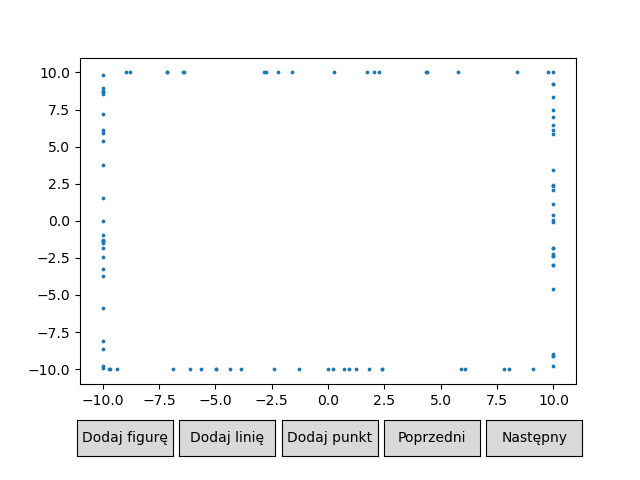

In [7]:
# n losowych punktów leżących na bokach prostokąta o danych wierzchołkach 

%matplotlib notebook


def generate_rectangle(n, lower_left, lower_right, upper_right, upper_left):
    width = lower_right[0] - lower_left[0]
    height = upper_right[1] - lower_right[1]
    
    set_c = [None]*n
    
    for i in range(n):
        rand_coordinate = random.uniform(0,2*width + 2*height)

        if rand_coordinate <= width:
            # punkt na dolnym boku
            set_c[i] = (lower_left[0] + (rand_coordinate % width), lower_left[1])

        elif rand_coordinate <= width + height:
            # punkt na prawym boku
            set_c[i] = (lower_right[0], lower_right[1] + (rand_coordinate % height))

        elif rand_coordinate <= 2 * width + height:
            # punkt na górnym boku
            set_c[i] = (upper_left[0] + (rand_coordinate % width), upper_left[1])

        else:
            # punkt na lewym boku
            set_c[i] = (lower_left[0], lower_left[1] + (rand_coordinate % height))
    return set_c
    

# n = 100, (-10,-10), (10,-10), (10,10), (-10,10)
set_c = generate_rectangle(100, (-10,-10), (10,-10), (10,10), (-10,10))

plot = Plot(points = [PointsCollection(set_c, s=3)])
plot.draw()

<IPython.core.display.Javascript object>


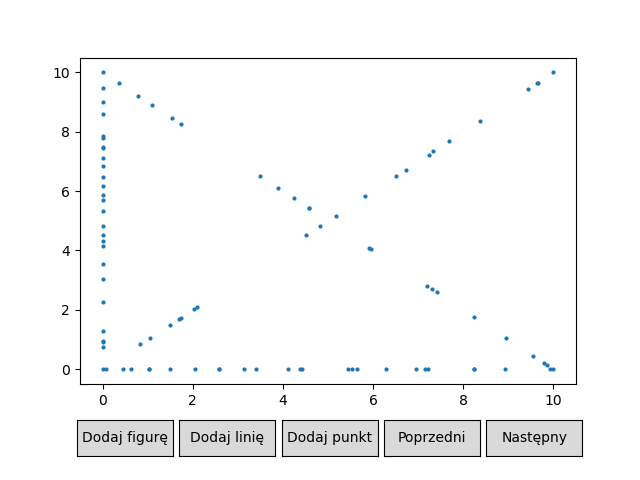

In [8]:
# kwadrat, którego jeden z wierzchołków to punkt (0,0), 2 leżą na osiach x oraz y,
# do generowania punktów potrzeba tylko punktu leżącego poza osiami x oraz y (off_axes)

%matplotlib notebook

def generate_square(on_axes, on_diagonals, off_axes):

    set_d = [(0,0), off_axes, (0,off_axes[1]), (off_axes[0],0)]
    
   
    # 1. losowe punkty na bokach leżących na osiach 
    for i in range(on_axes):
        set_d.append((0,random.uniform(0,off_axes[1])))
        set_d.append((random.uniform(0,off_axes[0]),0))

    # 2. losowe punkty leżące na przekątnych
        
    # równanie parametryczne prostej przechodzącej przez punkty (x1,y1) i (x2,y2)
    # x = x1 + (x2 - x1)t  => t = (x - x1)/(x2 - x1)
    # y = y1 + (y2 - y1)t

    a = [0,0]
    b = off_axes
    c = [0,off_axes[1]]
    d = [off_axes[0],0]

    for i in range(on_diagonals):
        x1  = random.uniform(0,off_axes[0])
        t1 = (x1 - a[0])/(b[0] - a[0])
        y1 = a[1] + (b[1] - a[1])*t1
        set_d.append((x1,y1))

        x2  = random.uniform(0,off_axes[0])
        t2 = (x2 - c[0])/(d[0] - c[0])
        y2 = c[1] + (d[1] - c[1])*t2
        set_d.append((x2,y2))
    return set_d


set_d = generate_square(25,20,(10,10))
plot = Plot(points = [PointsCollection(set_d, s=4)])
plot.draw()


# Otoczka wypukła

## Wizualizacja - Jarvis

In [9]:
def visualize_Jarvis(points, hull):
    scenes = [Scene([PointsCollection(points, s = 12, color = 'darkorange')])]
    
    for i in range(len(hull)):
        if i == 0:
            scenes.append(Scene([PointsCollection(points, s = 12, color = 'darkorange'), 
               PointsCollection([hull[0]], color = 'limegreen', s = 40)]))
            
        else:
            scenes.append(Scene(
                [PointsCollection(points, s = 12, color = 'darkorange'),
                 PointsCollection([hull[i]], color = 'limegreen', s = 40),
                 PointsCollection(hull[:i], color = 'mediumblue', s = 20)],
                
                [LinesCollection([[hull[i-1],hull[i]]], color = 'limegreen'),
                 LinesCollection([[hull[j],hull[j+1]] for j in range(i-1)], color = 'mediumblue')]))
    
    scenes.append(Scene([PointsCollection(points, s = 12, color = 'darkorange'),
                         PointsCollection(hull[:], color = 'mediumblue', s = 20)],
                        [LinesCollection([[hull[j],hull[j+1]] for j in range(len(hull)-1)]+[[hull[0], hull[-1]]], color = 'mediumblue')]))
    

    return scenes

## Algorytm Jarvisa

In [10]:
def save_as_file(hull, name):
    file = open(name+".txt","w") 
    
    for point in hull: 
        file.write(str(point)+'\n') 
 
    file.close()

In [11]:
def det(a,b,c):
    return a[0]*b[1] + b[0]*c[1] + a[1]*c[0] - c[0]*b[1] - b[0]*a[1] - a[0]*c[1]

In [12]:
def distance(a,b):
    return math.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)

In [13]:
# znajduje kolejny punkt otoczki

def find_next(points, last, e):
    best = points[0]
    
    for i in range(1,len(points)):
        current = points[i]
        
        Det = det(last, best, current)
        if Det < -e:
            best = current
#             print("< ",Det)
#             print(last, best, current,"\n")
            
        elif Det >-e and Det < e:
            # dalszy
            if distance(last, current) > distance(last, best):
                best = current
#                 print("= ",Det)
#                 print(last, best, current,"\n")
               
    return best
       

In [14]:
# darkorange - wszystkie
# mediumblue - otoczka
# limegreen - aktualny


def Jarvis(points, to_file = False, name = None, e=10**-10):
    Points = points.copy()
    
    first = min(points, key = lambda a: (a[1],a[0]))
    hull = [first]
                   
                    
    Next = None
    while Next != first and len(points) > 0:
       
        Next = find_next(Points,hull[-1],e)
        if Next != first:
            hull.append(Next)
                    
        Points.remove(Next)
        
    if to_file:
        save_as_file(hull, name)
        
    print("Jarvis: %d points" %len(hull))       
    return hull      

## set_a

Jarvis: 10 points
10


<IPython.core.display.Javascript object>


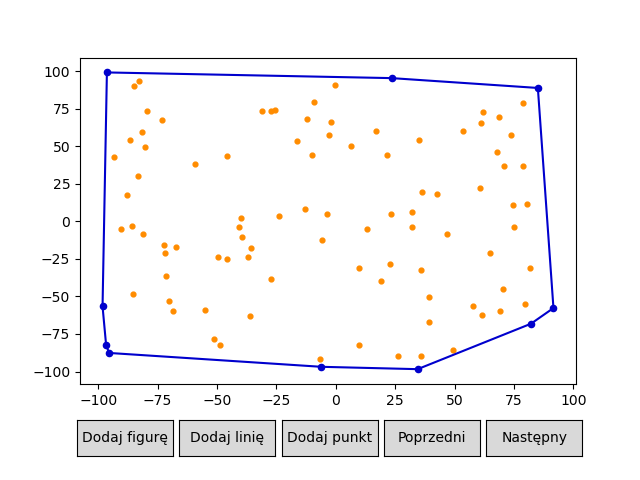

In [18]:
%matplotlib notebook

hull = Jarvis(set_a, to_file = True, name = "Jarvis_a")
print(len(hull))
scenes = visualize_Jarvis(set_a, hull)

plot=Plot(scenes = scenes)
plot.draw() 

## set_b


Jarvis: 100 points


<IPython.core.display.Javascript object>


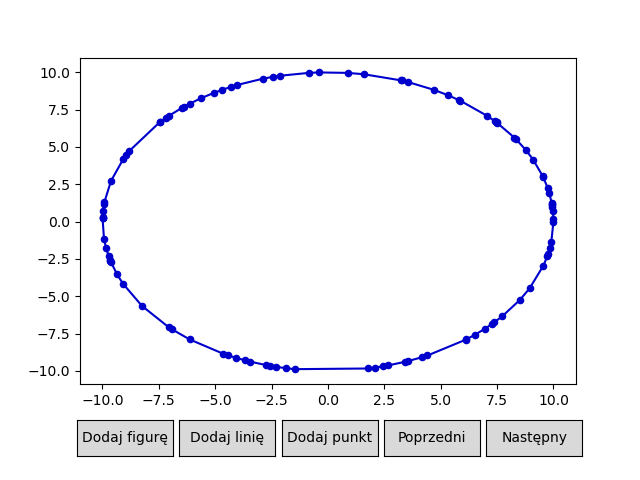

In [19]:
%matplotlib notebook

hull = Jarvis(set_b)
scenes = visualize_Jarvis(set_b, hull)

plot=Plot(scenes = scenes)
plot.draw() 

## set_c

Jarvis: 8 points


<IPython.core.display.Javascript object>


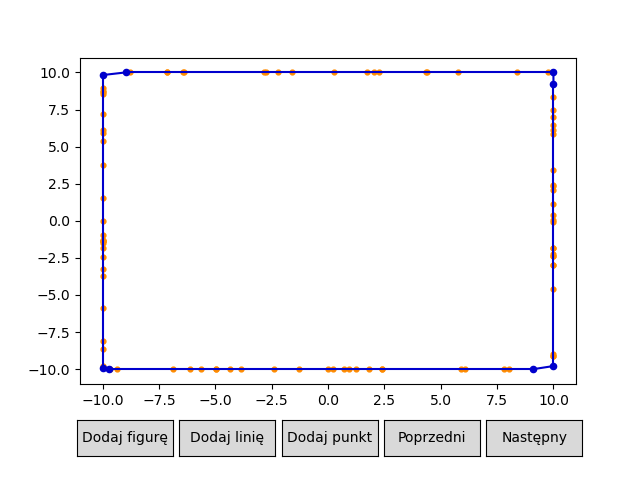

In [20]:
%matplotlib notebook

hull = Jarvis(set_c)
scenes = visualize_Jarvis(set_c, hull)

plot=Plot(scenes = scenes)
plot.draw()

## set_d

Jarvis: 4 points


<IPython.core.display.Javascript object>


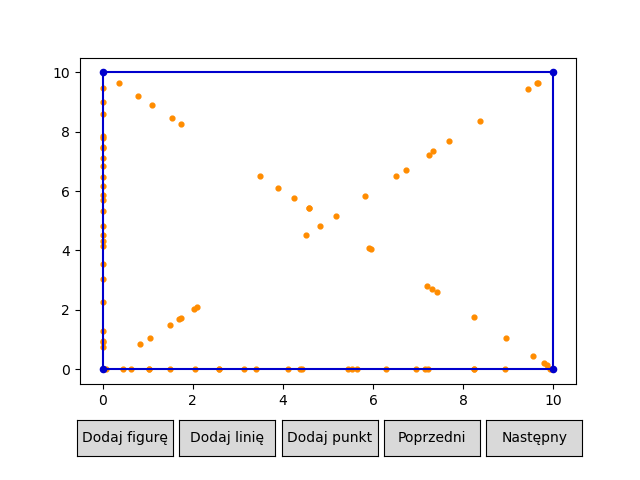

In [21]:
%matplotlib notebook

hull = Jarvis(set_d)
scenes = visualize_Jarvis(set_d, hull)

plot=Plot(scenes = scenes)
plot.draw()

## Wizualizacja - Graham

In [22]:
def add_scene(scenes,points,stack,sorted_points,i,which):
    
    if which == "first":
        scenes.append(Scene([PointsCollection(points, s = 12, color = 'darkorange')]))
        
    if which == "second":
        scenes.append(Scene([PointsCollection(points, s = 12, color = 'darkorange'),
                         PointsCollection(stack[:], color = 'mediumblue', s = 20)],
                        [LinesCollection([[stack[j],stack[j+1]] for j in range(len(stack)-1)], color = 'mediumblue')]))
        
    elif which == "next":
        scenes.append(Scene([PointsCollection(points, s = 12, color = 'darkorange'),
                         PointsCollection(stack[:], color = 'mediumblue', s = 20),
                            PointsCollection([sorted_points[i]], color = 'limegreen', s = 40)],
                        [LinesCollection([[stack[j],stack[j+1]] for j in range(len(stack)-1)], color = 'mediumblue'),
                        LinesCollection([[sorted_points[i-1],sorted_points[i]]], color = 'limegreen')]))
        
    elif which == "popped":
        scenes.append(Scene([PointsCollection(points, s = 12, color = 'darkorange'),
                         PointsCollection(stack[:], color = 'mediumblue', s = 20),
                         PointsCollection([sorted_points[i]], color = 'limegreen', s = 40)],
                        [LinesCollection([[stack[j],stack[j+1]] for j in range(len(stack)-1)], color = 'mediumblue'),
                        LinesCollection([[stack[-1],sorted_points[i]]], color = 'limegreen')]))
    
    elif which == "last":
        scenes.append(Scene([PointsCollection(points, s = 12, color = 'darkorange'),
                         PointsCollection(stack[:], color = 'mediumblue', s = 20)],
                        [LinesCollection([[stack[j],stack[j+1]] for j in range(len(stack)-1)] + [[stack[-1],stack[0]]], color = 'mediumblue')]))
        
    
    

## Algorytm Grahama

In [23]:
def angle_sort(points,first,e):
    
    # zwraca punkt, mający mniejszą współrzędną kątową względem pierwszego
    def compare(first,a,b,e):
        Det = det(first,a,b)
        if Det < -e:
            return b
            
        elif Det < e and Det > -e:
            # dalszy
            if distance(first, a) > distance(first, b):
                return b
            else: 
                return a
        else:
            return a

    def partition(arr,p,k,first):
        pivot = arr[k]  
        i = p  
        
        for j in range(p,k):
            if compare(first,pivot,arr[j],e) == arr[j]:
                arr[j],arr[i] = arr[i],arr[j]
                i = i + 1

        arr[i],arr[k] = arr[k],arr[i]
        return i   

    def quickSort(arr,p,k,first):
        if (p < k):   

            piv = partition(arr,p,k,first)  
           
            quickSort(arr,p,piv-1,first)
            quickSort(arr,piv+1,k,first)

        return arr
   
    return quickSort(points, 0, len(points)-1, first)

In [24]:
def Graham(points, to_file = False, name = None, e = 10**-10, visualize = False):
    if visualize: 
        scenes = []
    Points = points.copy()
    
    first = min(points, key = lambda a: (a[1],a[0]))
    Points.remove(first)
    
    sorted_points = [first] + angle_sort(Points,first,e)
    # usuwamy punkty o tym samym kącie, oprócz najdalszego
    for i in range(1,len(sorted_points)):
        while (i < len(sorted_points)-1 and 
        det(first,sorted_points[i], sorted_points[i+1]) < e and 
        det(first,sorted_points[i], sorted_points[i+1]) > -e):    
            del sorted_points[i]
            
    
    if len(sorted_points) >= 3:  
        stack = sorted_points[:3]
        
        if visualize:
            add_scene(scenes,points,stack,sorted_points,None, "first")
            add_scene(scenes,points,stack,sorted_points,None, "second")
    
    for i in range(3, len(sorted_points)):
        if visualize:
            add_scene(scenes,points,stack,sorted_points,i, "next")
        
        while det(stack[-2],stack[-1], sorted_points[i]) <= e:
            stack.pop()
            
            if visualize:
                add_scene(scenes,points,stack,sorted_points,i, "popped")
            
        stack.append(sorted_points[i])
    
    if to_file:
        save_as_file(stack, name)
    
    print("Graham: %d points" %len(stack))
    if visualize:
        add_scene(scenes,points,stack,sorted_points,None, "last")
        
    if not visualize:
        return stack
    
    else:
        return stack,scenes     

## set_a

Graham: 12 points


<IPython.core.display.Javascript object>


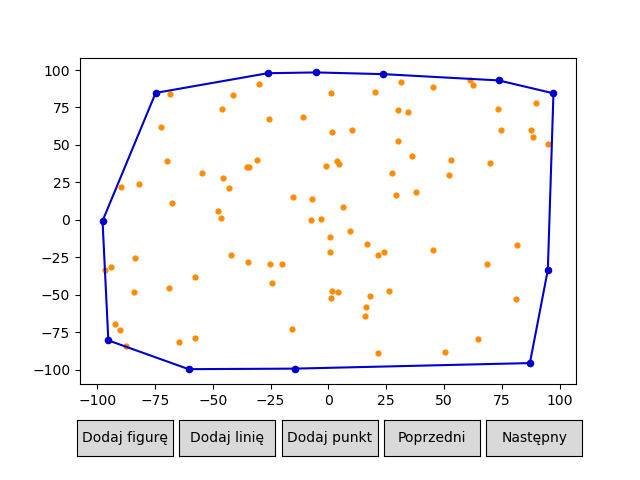

In [25]:
%matplotlib notebook

set_a = generate_points(100, [-100,100])

hull,scenes = Graham(set_a,visualize=True,to_file=True, name="Graham_a")
plot=Plot(scenes = scenes)
plot.draw()

## set_b

Graham: 100 points


<IPython.core.display.Javascript object>


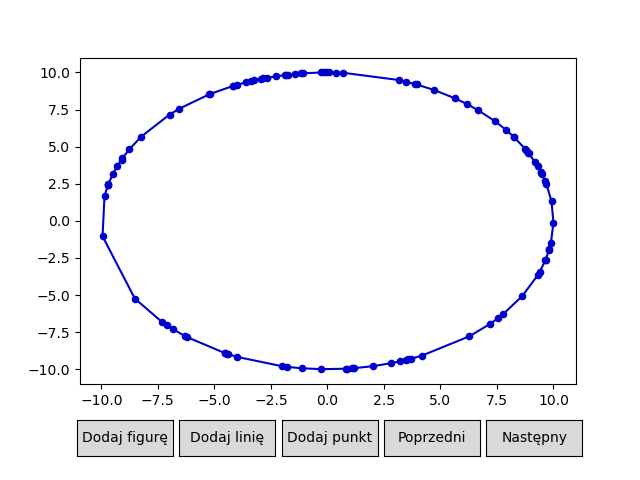

In [26]:
%matplotlib notebook

set_b = generate_circle(100, (0,0), 10)

hull,scenes = Graham(set_b,visualize=True)
plot=Plot(scenes = scenes)
plot.draw()

## set_c

Graham: 8 points
8


<IPython.core.display.Javascript object>


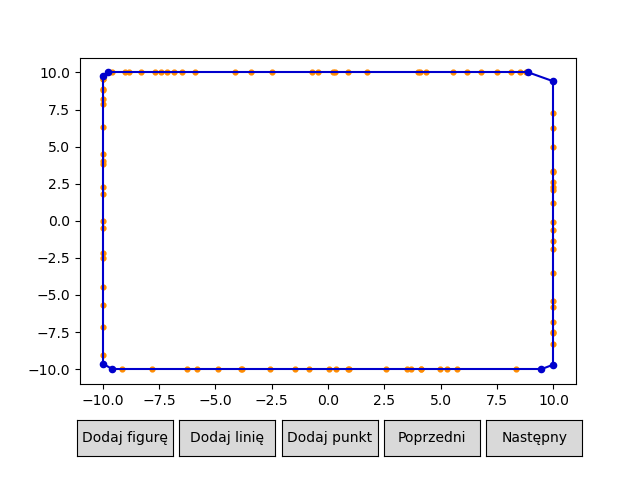

In [27]:
%matplotlib notebook

set_c = generate_rectangle(100, (-10,-10), (10,-10), (10,10), (-10,10))

hull,scenes = Graham(set_c,visualize=True)
print(len(hull))
plot=Plot(scenes = scenes)
plot.draw()

## set_d

Graham: 4 points
4


<IPython.core.display.Javascript object>


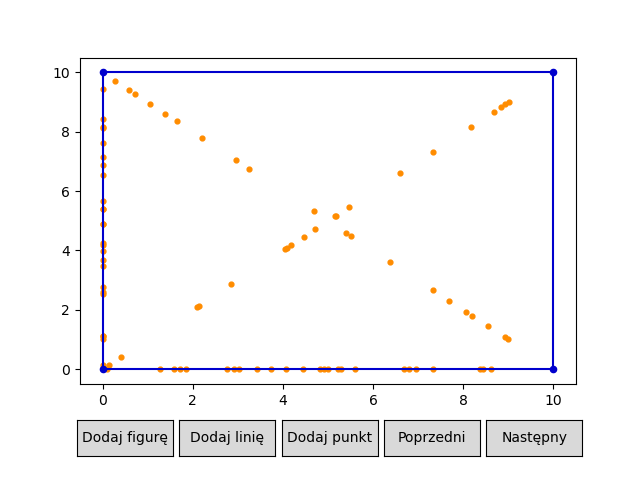

In [28]:
%matplotlib notebook

set_d = generate_square(25,20,(10,10))

hull,scenes = Graham(set_d,visualize=True,to_file=True, name="Graham_d")
print(len(hull))
plot=Plot(scenes = scenes)
plot.draw()

## Pomiar czasu działania

In [29]:
def execution_time(points, e=10**-10):
    
    start = time.time()
    Jarvis(points,e=e)
    Jarvis_ex = time.time() - start
    print("Jarvis:", Jarvis_ex,"[s]")
    
    start = time.time()
    Graham(points,e=e)
    Graham_ex = time.time() - start
    print("Graham:", Graham_ex,"[s]")
    
    if Jarvis_ex != 0:
        # stosunek czasu działania alg. Grahama do alg. Jarvisa
        GJratio = round(Graham_ex/Jarvis_ex,2)
    else:
        GJratio = math.inf
    print("ratio: ", GJratio, "\n")


### Zbiory wyjściowe 

In [30]:
a = generate_points(100, [-100,100])
b = generate_circle(100, (0,0), 10)
c = generate_rectangle(100, (-10,-10), (10,-10), (10,10), (-10,10))
d = generate_square(25,20,(10,10))

arr = [a,b,c,d]
for Set in arr:
    execution_time(Set)

Jarvis: 11 points
Jarvis: 0.0019600391387939453 [s]
Graham: 11 points
Graham: 0.0009970664978027344 [s]
ratio:  0.51 

Jarvis: 100 points
Jarvis: 0.005982398986816406 [s]
Graham: 100 points
Graham: 0.000997304916381836 [s]
ratio:  0.17 

Jarvis: 8 points
Jarvis: 0.0009970664978027344 [s]
Graham: 8 points
Graham: 0.001995086669921875 [s]
ratio:  2.0 

Jarvis: 4 points
Jarvis: 0.0009970664978027344 [s]
Graham: 4 points
Graham: 0.0019941329956054688 [s]
ratio:  2.0 



### Zbiór a dla 1000, 10000, 100000 punktów

In [31]:
a = generate_points(1000, [-1000,1000])

execution_time(a)

Jarvis: 19 points
Jarvis: 0.021962404251098633 [s]
Graham: 20 points
Graham: 0.02487778663635254 [s]
ratio:  1.13 



In [32]:
a = generate_points(10000, [-10000,10000])

execution_time(a)

Jarvis: 25 points
Jarvis: 0.2483358383178711 [s]
Graham: 25 points
Graham: 0.24673938751220703 [s]
ratio:  0.99 



In [33]:
a = generate_points(100000, [-1000000,1000000])

execution_time(a)

Jarvis: 34 points
Jarvis: 5.413492441177368 [s]
Graham: 34 points
Graham: 2.8659842014312744 [s]
ratio:  0.53 



### Zbiór b dla 1000, 4000, 7000 punktów

In [52]:
b = generate_circle(1000, (0,0), 1000)

execution_time(b)

Jarvis: 1000 points
Jarvis: 0.48583459854125977 [s]
Graham: 1000 points
Graham: 0.019029855728149414 [s]
ratio:  0.04 



In [53]:
b = generate_circle(4000, (0,0), 1000)

execution_time(b)

Jarvis: 4000 points
Jarvis: 7.660582542419434 [s]
Graham: 4000 points
Graham: 0.09165143966674805 [s]
ratio:  0.01 



In [54]:
b = generate_circle(7000, (0,0), 10000)

execution_time(b)

Jarvis: 7000 points
Jarvis: 23.83830952644348 [s]
Graham: 7000 points
Graham: 0.1546006202697754 [s]
ratio:  0.01 



### Zbiór c dla 1000, 10000, 100000 punktów

In [49]:
c = generate_rectangle(1000, (-1000,-1000), (1000,-1000), (1000,1000), (-1000,1000))

execution_time(c,10**-7)

Jarvis: 8 points
Jarvis: 0.020907163619995117 [s]
Graham: 8 points
Graham: 0.024991512298583984 [s]
ratio:  1.2 



In [50]:
c = generate_rectangle(10000, (-10000,-10000), (10000,-10000), (10000,10000), (-10000,10000))

execution_time(c,10**-7)

Jarvis: 8 points
Jarvis: 0.12052178382873535 [s]
Graham: 8 points
Graham: 0.3299384117126465 [s]
ratio:  2.74 



In [51]:
c = generate_rectangle(100000, (-10000,-10000), (10000,-10000), (10000,10000), (-10000,10000))

execution_time(c,10**-7)

Jarvis: 8 points
Jarvis: 1.201056957244873 [s]
Graham: 8 points
Graham: 5.119694948196411 [s]
ratio:  4.26 



### Zbiór d dla 2000, 20000, 200000 punktów

In [44]:
d = generate_square(500,500,(100,100))

execution_time(d)

Jarvis: 4 points
Jarvis: 0.01898479461669922 [s]
Graham: 4 points
Graham: 0.06983590126037598 [s]
ratio:  3.68 



In [45]:
d = generate_square(5000,5000,(1000,1000))

execution_time(d)

Jarvis: 4 points
Jarvis: 0.11568903923034668 [s]
Graham: 4 points
Graham: 1.1199710369110107 [s]
ratio:  9.68 



In [46]:
d = generate_square(50000,50000,(10000,10000))

execution_time(d)

Jarvis: 4 points
Jarvis: 1.1170272827148438 [s]
Graham: 4 points
Graham: 19.969552278518677 [s]
ratio:  17.88 

